## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

## Helper Functions

In [2]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines,color=[255, 0, 0], thickness=6):
    ysize =img.shape[0]
    xsize =img.shape[1]
    
    #Create Slope and Center arrays
    rm=[]
    lm=[]
    rc=[]
    lc=[]
    
    #Sort slopes and centers into right or left
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            center = ((x2+x1)/2,(y2+y1)/2)
            if (-0.85 < slope < -0.35) and (x1< xsize/2) and (x2< xsize/2) :
                lm.append(slope)
                lc.append(center)
            elif (0.35 < slope < 0.85) and (x1> xsize/2) and (x2> xsize/2):
                rm.append(slope)
                rc.append(center)
    #Get Slope and Center of single line
    r_slope = np.sum(rm)/len(rm)
    l_slope = np.sum(lm)/len(lm)
    r_center = np.divide(np.sum(rc,axis=0),len(rc))
    l_center = np.divide(np.sum(lc,axis=0),len(lc))


    #Find two points across the length to draw line
    y1 = int( 0.63*ysize)
    x1 = int(((y1-l_center[1])/(l_slope))+l_center[0])
    y2 = 540
    x2 = int(((y2-l_center[1])/(l_slope))+l_center[0])
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    y1 =int( 0.63*ysize)
    x1 = int(((y1-r_center[1])/(r_slope))+r_center[0])
    y2 = 540
    x2 = int(((y2-r_center[1])/(r_slope))+r_center[0])
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Pipeline

In [3]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray = grayscale(image)

    # Gaussian Smoothing
    kernel_size = 3
    blur = gaussian_blur(gray, kernel_size)

    #Edge Detection
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur, low_threshold, high_threshold)
    
    # Mask pixels below the threshold
    color_thresholds = (image[:,:,0] < 200) | \
                    (image[:,:,1] < 200) | \
                    (image[:,:,2] < 200)

    #Masked Edges
    imshape = image.shape
    #vertices =np.array([[(0,imshape[0]),(325,350), (650,350), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices =np.array([[(0.51*imshape[1],imshape[0]*0.58), (0.49*imshape[1],0.58*imshape[0]),(0,imshape[0]),(imshape[1],imshape[0])]], dtype=np.int32)
    roi = region_of_interest(edges, vertices)
    #roi[color_thresholds] = 0
    
    #Hough Transform
    rho = 1
    theta = 1*(np.pi/180)
    threshold = 35     
    min_line_len = 5 
    max_line_gap = 2 
    line_img = hough_lines(roi, rho, theta, threshold, min_line_len, max_line_gap)

    #Get Hough Lines
    lines = cv2.HoughLinesP(roi, rho, theta, threshold, np.array([]),
                            min_line_len, max_line_gap)
   
    laneLine = np.copy(image)*0
    draw_lines(laneLine, lines, color=[255, 0, 0], thickness=6)
    lane_image = cv2.addWeighted(image, 0.7, laneLine, 1.5, 0) 
    return lane_image

## Test Images and Sample Output

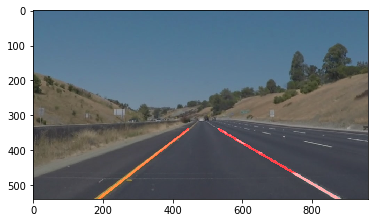

In [4]:
import os
testImages = os.listdir("test_images/")

for test in testImages:
    if(test[0:6]) !="output":
        image = mpimg.imread("test_images/"+test)
        result = process_image(image)
        plt.imshow(result)
        r,g,b = cv2.split(result)
        result = cv2.merge((b,g,r))
        cv2.imwrite("test_images_output/"+test,result)

## Test Video : 1

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)



[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:05<00:00, 40.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 6.72 s


In [6]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Test Video : 2

In [7]:
white_output =  'test_videos_output/solidYellowLeft.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)



[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:18<00:00, 37.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 18.9 s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))